<a href="https://colab.research.google.com/github/JeanMusenga/PhD-Thesis_2024_Musenga/blob/main/RoBERTa_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://chatgpt.com/share/4650a1f9-a8a4-4b31-b01f-aee216098c6e


In [1]:
import pandas as pd
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [6]:
import numpy as np
np.random.seed(42) #The random seed helps in the reproduction of the results

In [7]:
file_path = './saved_file'
file_path = ('posts.xlsx')

data = pd.read_excel(file_path)

# Split dataset

In [9]:
# Split dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['Question_body'].tolist(),
    data['Label'].tolist(),
    test_size=0.3,
    random_state=42
)

# Load the RoBERTa tokenizer and Tokenize Data

In [10]:
# Tokenize data
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

# Create dataset class

In [11]:
# Create dataset class
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Dataset(train_encodings, train_labels)
test_dataset = Dataset(test_encodings, test_labels)

# Load Model

In [12]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Define training arguments

In [13]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


# Define evaluation metric

In [14]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


# Create Trainer instance

In [16]:
# Initialize the Adam optimizer
import torch.optim as optim
adam_optimizer = optim.Adam(model.parameters(), lr=2e-5)

In [18]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    optimizers=(adam_optimizer, None)
)

# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.059000,0.129449,0.974554,0.974912,0.951052,1.000000
2,0.068700,0.110692,0.976786,0.977042,0.955940,0.999097
3,0.094200,0.111437,0.977232,0.977353,0.961555,0.993679


TrainOutput(global_step=3921, training_loss=0.11525321912359032, metrics={'train_runtime': 3654.5074, 'train_samples_per_second': 8.58, 'train_steps_per_second': 1.073, 'total_flos': 8250110251868160.0, 'train_loss': 0.11525321912359032, 'epoch': 3.0})

# Evaluate the model

In [19]:
# Evaluate the model
#trainer.evaluate()

# Evaluate the model
results = trainer.evaluate()
print(results)

{'eval_loss': 0.11143695563077927, 'eval_accuracy': 0.9772321428571429, 'eval_f1': 0.9773534635879217, 'eval_precision': 0.9615552643075579, 'eval_recall': 0.9936794582392776, 'eval_runtime': 143.4854, 'eval_samples_per_second': 31.223, 'eval_steps_per_second': 3.903, 'epoch': 3.0}


# Make predictions on Evaluation dataset

In [20]:
# Make predictions
predictions = trainer.predict(test_dataset)
y_true = test_labels
y_pred = predictions.predictions.argmax(-1)

# Print metrics

In [24]:
# Print overall metrics
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
accuracy = accuracy_score(y_true, y_pred)

print(f'Overall Accuracy: {accuracy}')
print(f'Overall Precision: {precision}')
print(f'Overall Recall: {recall}')
print(f'Overall F1-score: {f1}')

# Print metrics for each class
precision_class, recall_class, f1_class, _ = precision_recall_fscore_support(y_true, y_pred, average=None, labels=[0, 1])

print(f'Class 0 - Precision: {precision_class[0]}, Recall: {recall_class[0]}, F1-score: {f1_class[0]}')
print(f'Class 1 - Precision: {precision_class[1]}, Recall: {recall_class[1]}, F1-score: {f1_class[1]}')


Overall Accuracy: 0.9772321428571429
Overall Precision: 0.9615552643075579
Overall Recall: 0.9936794582392776
Overall F1-score: 0.9773534635879217
Class 0 - Precision: 0.9936102236421726, Recall: 0.9611479028697572, F1-score: 0.9771095152603232
Class 1 - Precision: 0.9615552643075579, Recall: 0.9936794582392776, F1-score: 0.9773534635879217


In [25]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# Compute metrics for each class
precision_class, recall_class, f1_class, support_class = precision_recall_fscore_support(y_true, y_pred, average=None, labels=[0, 1])

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Extract TP, TN, FP, FN for each class
TP_0 = conf_matrix[0, 0]
FN_0 = conf_matrix[0, 1]
FP_0 = conf_matrix[1, 0]
TN_0 = conf_matrix[1, 1]

TP_1 = conf_matrix[1, 1]
FN_1 = conf_matrix[1, 0]
FP_1 = conf_matrix[0, 1]
TN_1 = conf_matrix[0, 0]

# Calculate accuracy for each class
accuracy_class_0 = (TP_0 + TN_0) / (TP_0 + TN_0 + FP_0 + FN_0)
accuracy_class_1 = (TP_1 + TN_1) / (TP_1 + TN_1 + FP_1 + FN_1)

print(f'Class 0 - Precision: {precision_class[0]}, Recall: {recall_class[0]}, Accuracy: {accuracy_class_0}, F1-score: {f1_class[0]}, Support: {support_class[0]}')
print(f'Class 1 - Precision: {precision_class[1]}, Recall: {recall_class[1]}, Accuracy: {accuracy_class_1}, F1-score: {f1_class[1]}, Support: {support_class[1]}')


Class 0 - Precision: 0.9936102236421726, Recall: 0.9611479028697572, Accuracy: 0.9772321428571429, F1-score: 0.9771095152603232, Support: 2265
Class 1 - Precision: 0.9615552643075579, Recall: 0.9936794582392776, Accuracy: 0.9772321428571429, F1-score: 0.9773534635879217, Support: 2215


In [ ]:
saved_model_path = './saved_model'
model.save_pretrained(saved_model_path)
tokenizer.save_pretrained(saved_model_path)

# Confusion Matrix
A confusion matrix provides a visual representation of the model's performance by showing the counts of true positive, true negative, false positive, and false negative predictions.

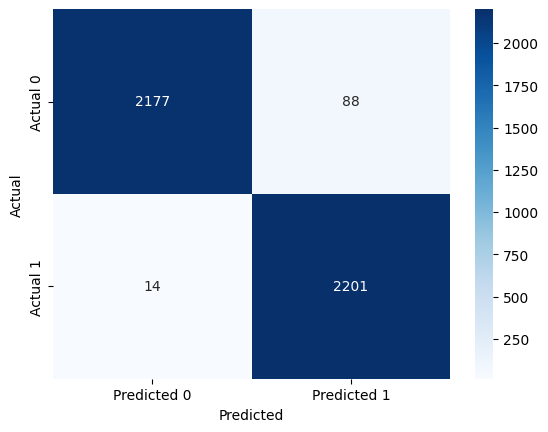

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()